In [1]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset

In [2]:
print("Versión de PyTorch:", torch.__version__)
print("Versión de CUDA usada por PyTorch:", torch.version.cuda)


Versión de PyTorch: 2.5.1
Versión de CUDA usada por PyTorch: 12.1


In [3]:
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr'
ds = xr.open_zarr(dataset_path, consolidated=True)
print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [4]:
print("Dimensiones del dataset:", ds.dims)

Dimensiones del dataset: FrozenMappingWarningOnValuesAccess({'time': 93544, 'longitude': 240, 'latitude': 121, 'level': 13})


In [71]:
subset = ds.isel(latitude=slice(0, 50), longitude=slice(0, 50), time=slice(0, 5))
print(subset)

<xarray.Dataset> Size: 12MB
Dimensions:                                           (time: 5, longitude: 50,
                                                       latitude: 50, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 400B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 400B ...
  * time                                              (time) datetime64[ns] 40B ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 50kB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 50kB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 50kB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 50kB ...
    2m_temperature                                

In [72]:
for var in subset.data_vars:
    print(f"{var}: {subset[var].shape}")

10m_u_component_of_wind: (5, 50, 50)
10m_v_component_of_wind: (5, 50, 50)
10m_wind_speed: (5, 50, 50)
2m_dewpoint_temperature: (5, 50, 50)
2m_temperature: (5, 50, 50)
above_ground: (5, 13, 50, 50)
ageostrophic_wind_speed: (5, 13, 50, 50)
angle_of_sub_gridscale_orography: (50, 50)
anisotropy_of_sub_gridscale_orography: (50, 50)
boundary_layer_height: (5, 50, 50)
divergence: (5, 13, 50, 50)
eddy_kinetic_energy: (5, 50, 50)
geopotential: (5, 13, 50, 50)
geopotential_at_surface: (50, 50)
geostrophic_wind_speed: (5, 13, 50, 50)
high_vegetation_cover: (50, 50)
integrated_vapor_transport: (5, 50, 50)
lake_cover: (50, 50)
land_sea_mask: (50, 50)
lapse_rate: (5, 13, 50, 50)
leaf_area_index_high_vegetation: (5, 50, 50)
leaf_area_index_low_vegetation: (5, 50, 50)
low_vegetation_cover: (50, 50)
mean_sea_level_pressure: (5, 50, 50)
mean_surface_latent_heat_flux: (5, 50, 50)
mean_surface_net_long_wave_radiation_flux: (5, 50, 50)
mean_surface_net_short_wave_radiation_flux: (5, 50, 50)
mean_surface_se

In [73]:
variables = ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity', 'mean_sea_level_pressure']

subset_selected = subset[variables]
print(subset_selected)

<xarray.Dataset> Size: 3MB
Dimensions:                  (time: 5, level: 13, longitude: 50, latitude: 50)
Coordinates:
  * latitude                 (latitude) float64 400B -90.0 -88.5 ... -18.0 -16.5
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * longitude                (longitude) float64 400B 0.0 1.5 3.0 ... 72.0 73.5
  * time                     (time) datetime64[ns] 40B 1959-01-01 ... 1959-01-02
Data variables:
    u_component_of_wind      (time, level, longitude, latitude) float32 650kB ...
    v_component_of_wind      (time, level, longitude, latitude) float32 650kB ...
    temperature              (time, level, longitude, latitude) float32 650kB ...
    specific_humidity        (time, level, longitude, latitude) float32 650kB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 50kB ...


In [74]:
train_idx = 3  # Timestamps para entrenamiento
val_idx = 4    # Timestamps para validación
test_idx = 5   # Timestamps para prueba

# Crear los conjuntos
train_data = subset_selected.isel(time=slice(0, train_idx))
val_data = subset_selected.isel(time=slice(train_idx, val_idx))
test_data = subset_selected.isel(time=slice(val_idx, test_idx))

# Confirmar tamaños
print(f"Train size: {train_data['time'].shape[0]} timestamps")
print(f"Val size: {val_data['time'].shape[0]} timestamps")
print(f"Test size: {test_data['time'].shape[0]} timestamps")


Train size: 3 timestamps
Val size: 1 timestamps
Test size: 1 timestamps


In [75]:
u_mean = train_data['u_component_of_wind'].mean().values
u_std = train_data['u_component_of_wind'].std().values
v_mean = train_data['v_component_of_wind'].mean().values
v_std = train_data['v_component_of_wind'].std().values
T_mean = train_data['temperature'].mean().values
T_std = train_data['temperature'].std().values
q_mean = train_data['specific_humidity'].mean().values
q_std = train_data['specific_humidity'].std().values
p_mean = train_data['mean_sea_level_pressure'].mean().values
p_std = train_data['mean_sea_level_pressure'].std().values

In [76]:
print(f"u_mean: {u_mean}, u_std: {u_std}")
print(f"v_mean: {v_mean}, v_std: {v_std}")
print(f"T_mean: {T_mean}, T_std: {T_std}")
print(f"q_mean: {q_mean}, q_std: {q_std}")
print(f"p_mean: {p_mean}, p_std: {p_std}")

u_mean: 7.663863658905029, u_std: 13.974626541137695
v_mean: -0.7824493050575256, v_std: 5.975970268249512
T_mean: 244.31552124023438, T_std: 24.694271087646484
q_mean: 0.0013965974794700742, q_std: 0.0030203547794371843
p_mean: 100022.3203125, p_std: 1284.899658203125


In [77]:
u_train = (train_data['u_component_of_wind'] - u_mean) / u_std
v_train = (train_data['v_component_of_wind'] - v_mean) / v_std
T_train = (train_data['temperature'] - T_mean) / T_std
q_train = (train_data['specific_humidity'] - q_mean) / q_std
p_train = (train_data['mean_sea_level_pressure'] - p_mean) / p_std

In [78]:
u_val = (val_data['u_component_of_wind'] - u_mean) / u_std
v_val = (val_data['v_component_of_wind'] - v_mean) / v_std
T_val = (val_data['temperature'] - T_mean) / T_std
q_val = (val_data['specific_humidity'] - q_mean) / q_std
p_val = (val_data['mean_sea_level_pressure'] - p_mean) / p_std

In [79]:
u_test = (test_data['u_component_of_wind'] - u_mean) / u_std
v_test = (test_data['v_component_of_wind'] - v_mean) / v_std
T_test = (test_data['temperature'] - T_mean) / T_std
q_test = (test_data['specific_humidity'] - q_mean) / q_std
p_test = (test_data['mean_sea_level_pressure'] - p_mean) / p_std

In [177]:
u_train_tensor = torch.tensor(u_train.values, dtype=torch.float32, requires_grad=True)
v_train_tensor = torch.tensor(v_train.values, dtype=torch.float32, requires_grad=True)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32, requires_grad=True)
q_train_tensor = torch.tensor(q_train.values, dtype=torch.float32, requires_grad=True)
p_train_tensor = torch.tensor(p_train.values, dtype=torch.float32, requires_grad=True)

In [81]:
u_val_tensor = torch.tensor(u_val.values, dtype=torch.float32)
v_val_tensor = torch.tensor(v_val.values, dtype=torch.float32)
T_val_tensor = torch.tensor(T_val.values, dtype=torch.float32)
q_val_tensor = torch.tensor(q_val.values, dtype=torch.float32)
p_val_tensor = torch.tensor(p_val.values, dtype=torch.float32)

In [82]:
u_test_tensor = torch.tensor(u_test.values, dtype=torch.float32)
v_test_tensor = torch.tensor(v_test.values, dtype=torch.float32)
T_test_tensor = torch.tensor(T_test.values, dtype=torch.float32)
q_test_tensor = torch.tensor(q_test.values, dtype=torch.float32)
p_test_tensor = torch.tensor(p_test.values, dtype=torch.float32)

In [83]:
# Verificar dimensiones
print(f"u_test_tensor: {u_test_tensor.shape}")
print(f"v_test_tensor: {v_test_tensor.shape}")
print(f"T_test_tensor: {T_test_tensor.shape}")
print(f"q_test_tensor: {q_test_tensor.shape}")
print(f"p_test_tensor: {p_test_tensor.shape}")

u_test_tensor: torch.Size([1, 13, 50, 50])
v_test_tensor: torch.Size([1, 13, 50, 50])
T_test_tensor: torch.Size([1, 13, 50, 50])
q_test_tensor: torch.Size([1, 13, 50, 50])
p_test_tensor: torch.Size([1, 50, 50])


In [84]:
pe_test_tensor = p_test_tensor.unsqueeze(1).repeat(1, 13, 1, 1)
pe_train_tensor = p_train_tensor.unsqueeze(1).repeat(1, 13, 1, 1)
pe_val_tensor =  p_val_tensor.unsqueeze(1).repeat(1, 13, 1, 1)

In [85]:
# Verificar valores de ejemplo
print(f"Ejemplo de u_test_tensor: {u_test_tensor[0, 0, 0, 0]}")
print(f"Ejemplo de v_test_tensor: {v_test_tensor[0, 0, 0, 0]}")
print(f"Ejemplo de T_test_tensor: {T_test_tensor[0, 0, 0, 0]}")
print(f"Ejemplo de q_test_tensor: {q_test_tensor[0, 0, 0, 0]}")
print(f"Ejemplo de pe_test_tensor: {pe_test_tensor[0, 0, 0, 0]}")

Ejemplo de u_test_tensor: -0.7994946241378784
Ejemplo de v_test_tensor: 0.6234625577926636
Ejemplo de T_test_tensor: -0.2519680857658386
Ejemplo de q_test_tensor: -0.4612972140312195
Ejemplo de pe_test_tensor: 0.08538483083248138


In [86]:
print(f"Forma de u_train_tensor: {u_train_tensor.shape}")
print(f"Forma de v_train_tensor: {v_train_tensor.shape}")
print(f"Forma de T_train_tensor: {T_train_tensor.shape}")
print(f"Forma de q_train_tensor: {q_train_tensor.shape}")
print(f"Forma de pe_train_tensor: {pe_train_tensor.shape}")

Forma de u_train_tensor: torch.Size([3, 13, 50, 50])
Forma de v_train_tensor: torch.Size([3, 13, 50, 50])
Forma de T_train_tensor: torch.Size([3, 13, 50, 50])
Forma de q_train_tensor: torch.Size([3, 13, 50, 50])
Forma de pe_train_tensor: torch.Size([3, 13, 50, 50])


In [194]:
longitudes = subset_selected['longitude'].values
latitudes = subset_selected['latitude'].values
levels = subset_selected['level'].values
times = subset_selected['time'].values

In [195]:
# Normalizar longitudes y latitudes
longitudes_min, longitudes_max = longitudes.min(), longitudes.max()
latitudes_min, latitudes_max = latitudes.min(), latitudes.max()
levels_min, levels_max = levels.min(), levels.max()

# Normalizar tiempo (asumiendo que ya has convertido a numérico)
times_numeric = (times - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
times_min, times_max = times_numeric.min(), times_numeric.max()

longitudes_normalized = (longitudes - longitudes_min) / (longitudes_max - longitudes_min + 1e-8)
latitudes_normalized = (latitudes - latitudes_min) / (latitudes_max - latitudes_min + 1e-8)
levels_normalized = (levels - levels_min) / (levels_max - levels_min + 1e-8)
times_normalized = (times_numeric - times_min) / (times_max - times_min + 1e-8)


In [198]:
print(f"Longitudes normalizadas: {longitudes_normalized.min()} - {longitudes_normalized.max()}")
print(f"Latitudes normalizadas: {latitudes_normalized.min()} - {latitudes_normalized.max()}")
print(f"Tiempos normalizados: {times_normalized.min()} - {times_normalized.max()}")
print(f"Niveles normalizados: {levels_normalized.min()} - {levels_normalized.max()}")


Longitudes normalizadas: 0.0 - 0.9999999998639456
Latitudes normalizadas: 0.0 - 0.9999999998639456
Tiempos normalizados: 0.0 - 0.9999999999998843
Niveles normalizados: 0.0 - 0.9999999999894736


In [157]:
print(f"Longitudes: {longitudes.shape}, Latitudes: {latitudes.shape}, Times: {times.shape}, Levels: {levels.shape}")

Longitudes: (50,), Latitudes: (50,), Times: (5,), Levels: (13,)


In [196]:
x_coords, y_coords, t_coords, level_coords = np.meshgrid(
    longitudes_normalized, latitudes_normalized, times_normalized[:u_train_tensor.shape[0]], levels_normalized, indexing="ij"
)

In [197]:
inputs = np.stack([
    x_coords.flatten(),
    y_coords.flatten(),
    t_coords.flatten(),
    level_coords.flatten()
], axis=1)

In [199]:
inputs_tensor = torch.tensor(inputs, dtype=torch.float32, requires_grad=True)


In [245]:
class PINNWithCNN(nn.Module):
    def __init__(self):
        super(PINNWithCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 5, kernel_size=3, stride=1, padding=1)  # Cambiar a 5 canales de salida

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.conv3(x)  # Última capa genera 5 canales
        return x


In [207]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128), 
            nn.Dropout(0.2),   
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        return self.layers(x)


In [28]:
def compute_accuracy(pred, true, tolerance=0.05):
    """
    Calcula el porcentaje de predicciones dentro de un rango de tolerancia.
    """
    relative_error = torch.abs((pred - true) / true)
    accurate_predictions = torch.sum(relative_error <= tolerance).item()
    total_predictions = true.numel()
    accuracy = accurate_predictions / total_predictions
    return accuracy * 100  # Porcentaje

In [109]:
def compute_gradients(pred, x):
    grad = torch.autograd.grad(pred.sum(), x, create_graph=True, retain_graph=True)[0]
    return grad[:, 0], grad[:, 1], grad[:, 2]  # Devuelve las derivadas parciales

In [204]:
def loss_pde(model, x, u_true, v_true, p_true, T_true, q_true, alpha=1.0, beta=1.0):
    pred = model(x)
    u_pred, v_pred, p_pred, T_pred, q_pred = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3], pred[:, 4]

    # Calcula gradientes para cada término
    u_x, u_y, u_t = compute_gradients(u_pred, x)
    v_x, v_y, v_t = compute_gradients(v_pred, x)
    T_x, T_y, T_t = compute_gradients(T_pred, x)
    q_x, q_y, q_t = compute_gradients(q_pred, x)
    p_x, p_y, _ = compute_gradients(p_pred, x)

    # Define los términos de la pérdida
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    loss_data = (
        torch.mean((u_pred - u_true) ** 2) +
        torch.mean((v_pred - v_true) ** 2) +
        torch.mean((p_pred - p_true) ** 2) +
        torch.mean((T_pred - T_true) ** 2) +
        torch.mean((q_pred - q_true) ** 2)
    )

    loss_physics = (
        torch.mean(momentum_u ** 2) +
        torch.mean(momentum_v ** 2) +
        torch.mean(continuity ** 2) +
        torch.mean(energy ** 2) +
        torch.mean(moisture ** 2)
    )

    loss_total = alpha * loss_data + beta * loss_physics
    return loss_total, loss_data, loss_physics


In [200]:
# Ajustar las dimensiones para que coincidan
u_train_flat = u_train_tensor.flatten()
v_train_flat = v_train_tensor.flatten()
T_train_flat = T_train_tensor.flatten()
q_train_flat = q_train_tensor.flatten()
p_train_flat = pe_train_tensor.flatten()

print(f"u_train_flat.requires_grad: {u_train_flat.requires_grad}")
print(f"v_train_flat.requires_grad: {v_train_flat.requires_grad}")
print(f"T_train_flat.requires_grad: {T_train_flat.requires_grad}")
print(f"q_train_flat.requires_grad: {q_train_flat.requires_grad}")
print(f"p_train_flat.requires_grad: {p_train_flat.requires_grad}")

print(f"Forma de inputs_tensor: {inputs_tensor.shape}")
print(f"Forma de u_train_flat: {u_train_flat.shape}")
print(f"Forma de v_train_flat: {v_train_flat.shape}")
print(f"Forma de T_train_flat: {T_train_flat.shape}")
print(f"Forma de q_train_flat: {q_train_flat.shape}")
print(f"Forma de p_train_flat: {p_train_flat.shape}")


u_train_flat.requires_grad: True
v_train_flat.requires_grad: True
T_train_flat.requires_grad: True
q_train_flat.requires_grad: True
p_train_flat.requires_grad: True
Forma de inputs_tensor: torch.Size([97500, 4])
Forma de u_train_flat: torch.Size([97500])
Forma de v_train_flat: torch.Size([97500])
Forma de T_train_flat: torch.Size([97500])
Forma de q_train_flat: torch.Size([97500])
Forma de p_train_flat: torch.Size([97500])


In [34]:
# Lista de batch sizes a probar
batch_sizes = [16, 32, 64, 128, 256, 256, 512]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resultados almacenados
batch_results = {}

for batch_size in batch_sizes:
    print(f"Probando batch_size = {batch_size}...")
    
    # Crear DataLoader con el batch size actual
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Inicializar el modelo y mover a GPU
    model = PINN().to(device)

    # Medir tiempo para procesar un batch
    start_time = time.time()
    for batch in loader:
        inputs, u_true, v_true, p_true, T_true, q_true = [t.to(device) for t in batch]
        with torch.no_grad():  # Solo evaluación, sin retropropagación
            pred = model(inputs)
        break  # Solo medir el primer batch
    elapsed_time_batch = time.time() - start_time

    # (Opcional) Medir tiempo para procesar toda una época
    start_time_epoch = time.time()
    for batch in loader:
        inputs, u_true, v_true, p_true, T_true, q_true = [t.to(device) for t in batch]
        with torch.no_grad():
            pred = model(inputs)
    elapsed_time_epoch = time.time() - start_time_epoch

    # Almacenar resultados
    batch_results[batch_size] = {
        "time_per_batch": elapsed_time_batch,
        "time_per_epoch": elapsed_time_epoch,
    }
    print(f"Batch size {batch_size}: Tiempo por batch = {elapsed_time_batch:.4f}s, Tiempo por época = {elapsed_time_epoch:.2f}s")

# Mostrar resultados finales
print("\nResultados finales:")
for batch_size, results in batch_results.items():
    print(
        f"Batch size {batch_size}: "
        f"Tiempo por batch = {results['time_per_batch']:.4f}s, "
        f"Tiempo por época = {results['time_per_epoch']:.2f}s"
    )


Probando batch_size = 16...
Batch size 16: Tiempo por batch = 0.0031s, Tiempo por época = 3.98s
Probando batch_size = 32...
Batch size 32: Tiempo por batch = 0.0061s, Tiempo por época = 2.72s
Probando batch_size = 64...
Batch size 64: Tiempo por batch = 0.0027s, Tiempo por época = 2.14s
Probando batch_size = 128...
Batch size 128: Tiempo por batch = 0.0042s, Tiempo por época = 2.02s
Probando batch_size = 256...
Batch size 256: Tiempo por batch = 0.0059s, Tiempo por época = 2.01s
Probando batch_size = 256...
Batch size 256: Tiempo por batch = 0.0062s, Tiempo por época = 2.21s
Probando batch_size = 512...
Batch size 512: Tiempo por batch = 0.0181s, Tiempo por época = 1.74s

Resultados finales:
Batch size 16: Tiempo por batch = 0.0031s, Tiempo por época = 3.98s
Batch size 32: Tiempo por batch = 0.0061s, Tiempo por época = 2.72s
Batch size 64: Tiempo por batch = 0.0027s, Tiempo por época = 2.14s
Batch size 128: Tiempo por batch = 0.0042s, Tiempo por época = 2.02s
Batch size 256: Tiempo por

In [214]:
dataset = TensorDataset(inputs_tensor, u_train_flat, v_train_flat, p_train_flat, T_train_flat, q_train_flat)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [219]:
def train_model(model, loader, inputs_tensor, u_train_flat, v_train_flat, p_train_flat, 
                T_train_flat, q_train_flat, optimizer, loss_pde, compute_accuracy, 
                device, alpha=1.0, beta=10.0, epochs=1000):
    model.to(device)
    inputs_tensor = inputs_tensor.to(device)
    u_train_flat = u_train_flat.to(device)
    v_train_flat = v_train_flat.to(device)
    p_train_flat = p_train_flat.to(device)
    T_train_flat = T_train_flat.to(device)
    q_train_flat = q_train_flat.to(device)

    loss_history = []
    accuracy_history = {
        "u": [],
        "v": [],
        "p": [],
        "T": [],
        "q": []
    }

    for epoch in range(epochs):
        model.train()  # Modo entrenamiento
        epoch_loss_total = 0.0
        start_time = time.time()

        for batch in loader:
            inputs, u_true, v_true, p_true, T_true, q_true = [t.to(device) for t in batch]

            optimizer.zero_grad()

            loss_total, loss_data, loss_physics = loss_pde(model, inputs, u_true, v_true, p_true, T_true, q_true, alpha, beta)
            loss_total.backward()
            optimizer.step()

            # Acumula la pérdida total
            epoch_loss_total += loss_total.item()

        loss_history.append(epoch_loss_total / len(loader))

        # Evaluar precisión después de la época
        model.eval()  # Modo evaluación (sin dropout, etc.)
        with torch.no_grad():
            predictions = model(inputs_tensor)
            u_pred, v_pred, p_pred, T_pred, q_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4]

            u_accuracy = compute_accuracy(u_pred, u_train_flat)
            v_accuracy = compute_accuracy(v_pred, v_train_flat)
            p_accuracy = compute_accuracy(p_pred, p_train_flat)
            T_accuracy = compute_accuracy(T_pred, T_train_flat)
            q_accuracy = compute_accuracy(q_pred, q_train_flat)

            # Registrar precisión
            accuracy_history["u"].append(u_accuracy)
            accuracy_history["v"].append(v_accuracy)
            accuracy_history["p"].append(p_accuracy)
            accuracy_history["T"].append(T_accuracy)
            accuracy_history["q"].append(q_accuracy)

        print(f"Epoch {epoch}, Loss Total: {epoch_loss_total / len(loader):.6f}, "
              f"Accuracy: u={u_accuracy:.2f}%, v={v_accuracy:.2f}%, p={p_accuracy:.2f}%, "
              f"T={T_accuracy:.2f}%, q={q_accuracy:.2f}%, time {time.time() - start_time:.2f} s")

    return loss_history, accuracy_history


In [270]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_history, accuracy_history = train_model(
    model=model,
    loader=loader,
    inputs_tensor=inputs_tensor,
    u_train_flat=u_train_flat,
    v_train_flat=v_train_flat,
    p_train_flat=p_train_flat,
    T_train_flat=T_train_flat,
    q_train_flat=q_train_flat,
    optimizer=optimizer,
    loss_pde=loss_pde,
    compute_accuracy=compute_accuracy,
    device=device,
    alpha=1.0,
    beta=10.0,
    epochs=10
)

Epoch 0, Loss Total: 6.493345, Accuracy: u=0.04%, v=0.12%, p=0.04%, T=0.43%, q=0.22%, time 19.57 s
Epoch 1, Loss Total: 4.921620, Accuracy: u=0.06%, v=0.15%, p=0.02%, T=0.85%, q=0.33%, time 19.73 s
Epoch 2, Loss Total: 4.877123, Accuracy: u=0.03%, v=0.06%, p=0.02%, T=0.95%, q=0.32%, time 19.11 s
Epoch 3, Loss Total: 4.737210, Accuracy: u=0.01%, v=0.18%, p=0.03%, T=1.59%, q=2.23%, time 19.79 s
Epoch 4, Loss Total: 4.658030, Accuracy: u=0.01%, v=0.11%, p=0.04%, T=1.83%, q=2.17%, time 19.96 s
Epoch 5, Loss Total: 4.628040, Accuracy: u=0.02%, v=0.19%, p=0.03%, T=1.56%, q=2.05%, time 19.86 s
Epoch 6, Loss Total: 4.580009, Accuracy: u=0.02%, v=0.10%, p=0.06%, T=1.68%, q=2.23%, time 19.65 s
Epoch 7, Loss Total: 4.408770, Accuracy: u=0.01%, v=0.22%, p=0.06%, T=4.38%, q=11.34%, time 19.70 s
Epoch 8, Loss Total: 4.231295, Accuracy: u=0.01%, v=0.18%, p=0.06%, T=4.59%, q=7.83%, time 19.74 s
Epoch 9, Loss Total: 4.172229, Accuracy: u=0.01%, v=0.31%, p=0.03%, T=4.86%, q=11.08%, time 19.74 s


In [271]:
# Datos originales: (97500, 4)
batch_size = 256  # Tamaño del batch
channels = 4  # Número de características (latitud, longitud, nivel, tiempo)
height, width = 50, 50  # Dimensiones espaciales

num_points = (97500 // (50 * 50)) * (50 * 50)  # Total divisible por 2500

# Truncar inputs_tensor
inputs_tensor_truncated = inputs_tensor[:num_points]

# Reorganizar al formato 4D
inputs_tensor_cnn = inputs_tensor_truncated.view(-1, channels, height, width)
print(f"Forma truncada para CNN: {inputs_tensor_cnn.shape}")

Forma truncada para CNN: torch.Size([39, 4, 50, 50])


In [272]:
print(f"Forma de inputs_tensor_cnn: {inputs_tensor_cnn.shape}")
print(f"Forma de u_train_flat: {u_train_flat[:num_points].shape}")
print(f"Forma de v_train_flat: {v_train_flat[:num_points].shape}")
print(f"Forma de p_train_flat: {p_train_flat[:num_points].shape}")
print(f"Forma de T_train_flat: {T_train_flat[:num_points].shape}")
print(f"Forma de q_train_flat: {q_train_flat[:num_points].shape}")


Forma de inputs_tensor_cnn: torch.Size([39, 4, 50, 50])
Forma de u_train_flat: torch.Size([97500])
Forma de v_train_flat: torch.Size([97500])
Forma de p_train_flat: torch.Size([97500])
Forma de T_train_flat: torch.Size([97500])
Forma de q_train_flat: torch.Size([97500])


In [273]:
u_train_cnn = u_train_flat[:num_points].view(-1, 1, height, width)
v_train_cnn = v_train_flat[:num_points].view(-1, 1, height, width)
p_train_cnn = p_train_flat[:num_points].view(-1, 1, height, width)
T_train_cnn = T_train_flat[:num_points].view(-1, 1, height, width)
q_train_cnn = q_train_flat[:num_points].view(-1, 1, height, width)

# Verificar formas
print(f"Forma de u_train_cnn: {u_train_cnn.shape}")
print(f"Forma de v_train_cnn: {v_train_cnn.shape}")
print(f"Forma de p_train_cnn: {p_train_cnn.shape}")
print(f"Forma de T_train_cnn: {T_train_cnn.shape}")
print(f"Forma de q_train_cnn: {q_train_cnn.shape}")

Forma de u_train_cnn: torch.Size([39, 1, 50, 50])
Forma de v_train_cnn: torch.Size([39, 1, 50, 50])
Forma de p_train_cnn: torch.Size([39, 1, 50, 50])
Forma de T_train_cnn: torch.Size([39, 1, 50, 50])
Forma de q_train_cnn: torch.Size([39, 1, 50, 50])


In [274]:
dataset_cnn = TensorDataset(
    inputs_tensor_cnn,  # Entrada para la CNN
    u_train_cnn,        # Salidas reorganizadas
    v_train_cnn,
    p_train_cnn,
    T_train_cnn,
    q_train_cnn
)

# Crear el DataLoader
loader_cnn = DataLoader(dataset_cnn, batch_size=batch_size, shuffle=True)
print(f"DataLoader creado con éxito: {len(loader_cnn)} batches")

DataLoader creado con éxito: 1 batches


In [275]:
print(f"Forma del dataset:")
for data in dataset_cnn[0]:
    print(data.shape)

Forma del dataset:
torch.Size([4, 50, 50])
torch.Size([1, 50, 50])
torch.Size([1, 50, 50])
torch.Size([1, 50, 50])
torch.Size([1, 50, 50])
torch.Size([1, 50, 50])


In [280]:
def loss_pde_cnn_1(model, inputs, u_true, v_true, p_true, T_true, q_true):
    pred = model(inputs)
    loss_data = (
        torch.mean((pred[:, 0, :, :] - u_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 1, :, :] - v_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 2, :, :] - p_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 3, :, :] - T_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 4, :, :] - q_true[:, 0, :, :]) ** 2)
    )
    return loss_data


In [285]:
def loss_pde_cnn(model, x, u_true, v_true, p_true, T_true, q_true, alpha=1.0, beta=1.0):
    pred = model(x)
    u_pred, v_pred, p_pred, T_pred, q_pred = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3], pred[:, 4]
    loss_data = (
        torch.mean((pred[:, 0, :, :] - u_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 1, :, :] - v_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 2, :, :] - p_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 3, :, :] - T_true[:, 0, :, :]) ** 2) +
        torch.mean((pred[:, 4, :, :] - q_true[:, 0, :, :]) ** 2)
    )
    
    # Calcula gradientes para cada término
    u_x, u_y, u_t = compute_gradients(u_pred, x)
    v_x, v_y, v_t = compute_gradients(v_pred, x)
    T_x, T_y, T_t = compute_gradients(T_pred, x)
    q_x, q_y, q_t = compute_gradients(q_pred, x)
    p_x, p_y, _ = compute_gradients(p_pred, x)

    # Define los términos de la pérdida
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y



    loss_physics = (
        torch.mean(momentum_u ** 2) +
        torch.mean(momentum_v ** 2) +
        torch.mean(continuity ** 2) +
        torch.mean(energy ** 2) +
        torch.mean(moisture ** 2)
    )

    loss_total = alpha * loss_data + beta * loss_physics
    return loss_total, loss_data, loss_physics


In [291]:
loss_history = []
loss_data_history = []
loss_physics_history = []
alpha = 0.5
beta = 1
model = PINNWithCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2)
epochs = 2000

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_loss_data = 0.0
    epoch_loss_physics = 0.0

    for batch in loader_cnn:
        inputs, u_true, v_true, p_true, T_true, q_true = [t.to(device) for t in batch]

        optimizer.zero_grad()
        # Pérdida con la primera función
        loss_total, loss_data, loss_physics = loss_pde_cnn(model, inputs, u_true, v_true, p_true, T_true, q_true, alpha=1.0, beta=0)
        loss_total.backward()
        optimizer.step()
        epoch_loss += loss_total.item()
        epoch_loss_data += loss_data.item()
        epoch_loss_physics += loss_physics.item()

    loss_history.append(epoch_loss / len(loader_cnn))
    loss_data_history.append(epoch_loss_data / len(loader_cnn))
    loss_physics_history.append(epoch_loss_physics / len(loader_cnn))

    print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {epoch_loss / len(loader_cnn):.6f}, "
          f"Data Loss: {epoch_loss_data / len(loader_cnn):.6f}, "
          f"Physics Loss: {epoch_loss_physics / len(loader_cnn):.6f}")


Epoch 1/2000, Total Loss: 5.014627, Data Loss: 5.014627, Physics Loss: 0.011629
Epoch 2/2000, Total Loss: 5.011332, Data Loss: 5.011332, Physics Loss: 0.011165
Epoch 3/2000, Total Loss: 5.006204, Data Loss: 5.006204, Physics Loss: 0.010533
Epoch 4/2000, Total Loss: 5.000912, Data Loss: 5.000912, Physics Loss: 0.010074
Epoch 5/2000, Total Loss: 4.996691, Data Loss: 4.996691, Physics Loss: 0.010010
Epoch 6/2000, Total Loss: 4.994057, Data Loss: 4.994057, Physics Loss: 0.010396
Epoch 7/2000, Total Loss: 4.992869, Data Loss: 4.992869, Physics Loss: 0.011141
Epoch 8/2000, Total Loss: 4.992626, Data Loss: 4.992626, Physics Loss: 0.012110
Epoch 9/2000, Total Loss: 4.992685, Data Loss: 4.992685, Physics Loss: 0.013069
Epoch 10/2000, Total Loss: 4.992468, Data Loss: 4.992468, Physics Loss: 0.013875
Epoch 11/2000, Total Loss: 4.991603, Data Loss: 4.991603, Physics Loss: 0.014431
Epoch 12/2000, Total Loss: 4.989995, Data Loss: 4.989995, Physics Loss: 0.014721
Epoch 13/2000, Total Loss: 4.987763, 

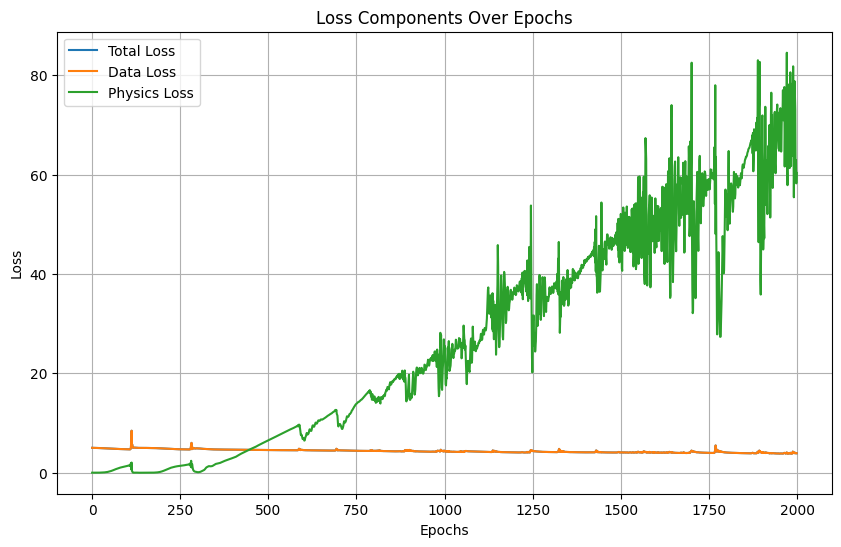

In [292]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_data_history, label='Data Loss')
plt.plot(loss_physics_history, label='Physics Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Components Over Epochs')
plt.legend()
plt.grid()
plt.show()